<a href="https://colab.research.google.com/github/devriesewouter89/CoGhentToiletPaper/blob/main/imageConversion/ArtLineFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CoGhent pipeline

a flow to go from a high frequent image, via line-art to a vector.

This allows us to plot it using only one color.

## **ArtLine**
**Create** **Amazing** **Line** **Art**.

based on https://github.com/vijishmadhavan/ArtLine.git

In [1]:
!git clone https://github.com/vijishmadhavan/ArtLine.git ArtLine

Cloning into 'ArtLine'...
remote: Enumerating objects: 491, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 491 (delta 5), reused 7 (delta 2), pack-reused 479
Receiving objects: 100% (491/491), 357.96 KiB | 2.26 MiB/s, done.
Resolving deltas: 100% (252/252), done.


In [2]:
cd ArtLine

/content/ArtLine


In [3]:
!pip install -r colab_requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 239 kB 4.2 MB/s 
     |████████████████████████████████| 20.3 MB 1.2 MB/s 
     |████████████████████████████████| 10.5 MB 37.0 MB/s 
     |████████████████████████████████| 748.8 MB 18 kB/s 
     |████████████████████████████████| 5.9 MB 25.5 MB/s 
     |████████████████████████████████| 332 kB 54.4 MB/s 
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19190 sha256=ba7e7a32a816eac4e672c116af58a1bb8b7b18a434adb6a0d304db3657d17335
  Stored in directory: /root/.cache/pip/wheels/df/99/da/c34f202dc8fd1dffd35e0ecf1a7d7f8374ca05fbcbaf974b83
Successfully built nvidia-ml-py3
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalli

# **Runtime**

* Hardware Accelerator = GPU 

In [4]:
import fastai
from fastai.vision import *
from fastai.utils.mem import *
from fastai.vision import open_image, load_learner, image, torch
import numpy as np
import urllib.request
import PIL.Image
from io import BytesIO
import torchvision.transforms as T
from PIL import Image
import requests
from io import BytesIO
import fastai
from fastai.vision import *
from fastai.utils.mem import *
from fastai.vision import open_image, load_learner, image, torch
import numpy as np
import urllib.request
import PIL.Image
from PIL import Image
from io import BytesIO
import torchvision.transforms as T

class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

def add_margin(pil_img, top, right, bottom, left, color):
    width, height = pil_img.size
    new_width = width + right + left
    new_height = height + top + bottom
    result = Image.new(pil_img.mode, (new_width, new_height), color)
    result.paste(pil_img, (left, top))
    return result

In [5]:
MODEL_URL = "https://www.dropbox.com/s/04suaimdpru76h3/ArtLine_920.pkl?dl=1 "
urllib.request.urlretrieve(MODEL_URL, "ArtLine_920.pkl")
path = Path(".")
learn=load_learner(path, 'ArtLine_920.pkl')

# **URL**
Type in a url to a direct link of an **high quality image**. Usually that means they'll end in .png, .jpg, etc. 

**Note** : Works well with **portrait photos having good lighting and plain background**. But you're free to explore.

Link to high-quality portrait pics. Click on the image, let it expand and then copy image address.

https://www.freepik.com/search?dates=any&format=search&from_query=Portrait&page=1&query=Portrait&sort=popular&type=photo

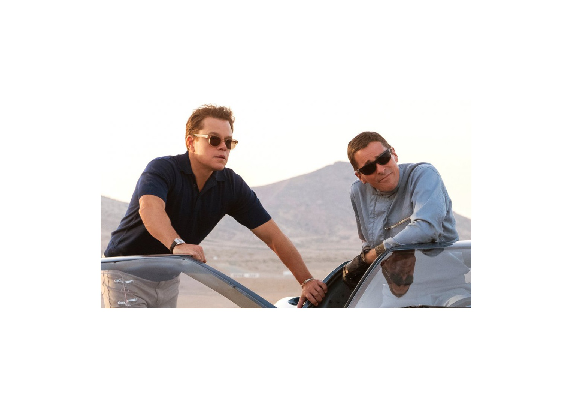

In [6]:
url = 'https://filmspell.com/wp-content/uploads/2019/12/ford-ferrari-anatomy-promo-videoSixteenByNine1050-990x556.jpg' #@param {type:"string"}

response = requests.get(url)
img = PIL.Image.open(BytesIO(response.content)).convert("RGB")
im_new = add_margin(img, 250, 250, 250, 250, (255, 255, 255))
im_new.save("test.jpg", quality=95)
img = open_image("test.jpg")
show_image(img, figsize=(10,10), interpolation='nearest');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


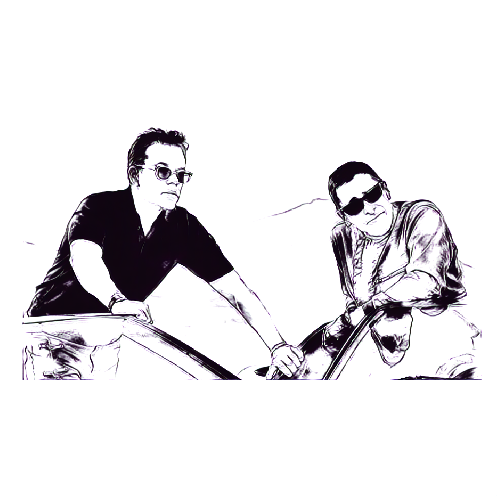

In [7]:
p,img_hr,b = learn.predict(img)
ax = show_image(img_hr, figsize=(9,9), interpolation='nearest');

## image to vector

In [9]:
import os
im_results = '/content/results'
os.makedirs(im_results)

In [10]:
fig = ax.get_figure()
name = "ford_ferrari"
fig_pth = os.path.join(im_results,'{}.png'.format(name))
fig.savefig(fig_pth)

In [11]:
#@markdown installing the necessary libraries
!apt install build-essential python-dev libagg-dev libpotrace-dev pkg-config
!pip install pypotrace
!git clone https://github.com/flupke/pypotrace.git /content/pypotrace
!pip install numpy
!pip install /content/pypotrace

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
pkg-config is already the newest version (0.29.1-0ubuntu2).
python-dev is already the newest version (2.7.15~rc1-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libpotrace0
The following NEW packages will be installed:
  libagg-dev libpotrace-dev libpotrace0
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 322 kB of archives.
After this operation, 3,208 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libagg-dev amd64 1:2.4-r127+dfsg1-1 [302 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libpotrace0 amd64 1.14-2 [17.4 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 libpotrace-dev am

In [16]:
# import potrace
# from potrace import Bitmap
# import numpy as np
# from PIL import Image

# # Initialize data, for example convert a PIL image to a numpy array
# # [...]
# # pix = np.array(img_hr)
# pix = Image.open(fig_pth)
# bitmap = Bitmap(pix)
# path = bitmap.trace()

TypeError: ignored

In [17]:
import os
svg_pth = os.path.join(im_results,'{}.svg'.format(name))

os.system("potrace {} --svg -o {}".format(fig_pth,svg_pth))


512

In [18]:
!apt install potrace imagemagick
cnvt_fig_pth = os.path.join(im_results,'{}.pnm'.format(name))

# cnvt_fig_pth = fig_pth.split('.')[0]+".pnm"
!convert {fig_pth} {cnvt_fig_pth}
!potrace {cnvt_fig_pth} --svg -o {svg_pth}

Reading package lists... Done
Building dependency tree       
Reading state information... Done
potrace is already the newest version (1.14-2).
imagemagick is already the newest version (8:6.9.7.4+dfsg-16ubuntu6.13).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [22]:
#@markdown show the resulting svg
with open(svg_pth) as f:
  a =f.readlines()


['<?xml version="1.0" standalone="no"?>\n', '<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 20010904//EN"\n', ' "http://www.w3.org/TR/2001/REC-SVG-20010904/DTD/svg10.dtd">\n', '<svg version="1.0" xmlns="http://www.w3.org/2000/svg"\n', ' width="648.000000pt" height="648.000000pt" viewBox="0 0 648.000000 648.000000"\n', ' preserveAspectRatio="xMidYMid meet">\n', '<metadata>\n', 'Created by potrace 1.14, written by Peter Selinger 2001-2017\n', '</metadata>\n', '<g transform="translate(0.000000,648.000000) scale(0.100000,-0.100000)"\n', 'fill="#000000" stroke="none">\n', '<path d="M2294 4479 c-4 -7 0 -9 13 -5 11 3 27 -1 39 -10 16 -13 16 -15 1 -10\n', '-9 3 -30 1 -45 -5 -15 -6 -40 -13 -55 -15 -16 -2 -37 -10 -48 -17 -22 -16 -64\n', '-72 -79 -105 -5 -13 -17 -30 -25 -38 -10 -11 -15 -38 -16 -87 0 -40 -2 -85 -5\n', '-102 -2 -16 1 -55 7 -85 22 -111 9 -125 -118 -135 -102 -7 -206 -23 -246 -38\n', '-41 -14 -104 -63 -118 -89 -8 -17 -3 -14 19 10 36 38 59 43 40 10 -7 -13 -11\n', '-26 -10 -30 1 -3 -5 -12 -13 -18

It's probably necessary to make the image less complex? 

combine lines which are close to each other?

## convert fills to hatches